# Assignment 2: Music Auto-tagging Model
- In this assignment, you will train your auto-tagging model using PyTorch
- The dataset is from MagnaTagATune
  - Randomly selected 8000 mp3 files
  - 5000 files for training, 1000 for validation, 2000 for test  
- Every code cell before the Problem 0 has to be ran without modification or error
- You have to submit three files:
  - Report in PDF (free format)
      - Explain what you have tried and what you have got as the result
      - Explain briefly of each code you wrote
  - Notebook in ipynb
  - Audio data that you used for Problem 7
 
- Problem 1: Complete Three Dataset Classes (21 pts)
- Problem 2: Practice with nn.Sequential() (5 pts)
- Problem 3: Make Your Own Conv Layers (10 pts)
- Probelm 4: Try Various Settings and Report (25 pts)
- Problem 5: Complete Binary Cross Entropy Function (4 pts)
- Problem 6: Complete Precision-Recall Area Under Curve Function (20 pts)
- Problem 7: Load audio and make prediction (15 pts)

In [79]:
DEV = 'cpu' # select your device 'cpu' or 'cuda'
# 슬프다... m1은 cuda가... :(

## 0. Import Library

In [80]:
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd
from datetime import datetime

def save_fig_with_date(figname):
  plt.savefig(f"{figname}_{datetime.now().strftime('%m_%d_%H_%M_%S')}.png")

- Download dataset from Google Drive link and Unzip at `MTAT_SMALL/`

In [81]:
'''
!pip install gdown
!gdown --id 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
!unzip -q mtat_8000.zip
'''

'\n!pip install gdown\n!gdown --id 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6\n!unzip -q mtat_8000.zip\n'

## Problem 1. Complete Dataset Class
- In this problem, you have to implement three ways to load the data
    - 1) Load audio file and resample every time the data is called 
    - 2) Save pre-processed data in .pt file and load it every time the data is called 
    - 3) Load every audio file on memory before the training starts

In [82]:
'''
You don't have to change this cell
'''
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __len__(self):
    return len(self.labels)
  

MTAT_DIR = Path('MTAT_SMALL/')

In [83]:
'''
Check how baseline dataset looks like
'''
base_set = MTATDataset(MTAT_DIR)
print(base_set.labels['mp3_path'][5813])
'''
metadata of dataset is stored in self.labels
'''
base_set.labels

6/philharmonia_baroque-rameau_and_leclair-03-entree_tres_gaye_des_troubadours__air_tres_gay__gavotte__menuet_rameau_les_paladins-30-59.mp3


,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
20552,45147,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2/zephyrus-angelus-11-ave_maria__virgo_serena_...
3899,8539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/tilopa-pictures_of_silence-02-ni-175-204.mp3
8996,19647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5/arthur_yoria-of_the_lovely-04-several_mistak...
4055,8856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/stargarden-music_for_modern_listening-02-per...
6361,13834,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,a/dac_crowell-the_mechanism_of_starlight-03-me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15397,33729,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4/jami_sieber-second_sight-07-the_goats_earth-...
19285,42374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9/self_delusion-happiness_hurts_me-10-dead_sta...
4099,8934,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/jamie_janover-now_center_of_time-02-playa-20...
18897,41453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2/jesse_manno-sea_spirits-09-tidur-59-88.mp3


In [84]:
base_set.label_tensor[10]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [85]:
'''
You can use labels['mp3_path'].iloc
'''
target_idx = 0 

path_to_target_idx = base_set.labels['mp3_path'].iloc[target_idx]
print(path_to_target_idx)

2/zephyrus-angelus-11-ave_maria__virgo_serena_josquin_des_prez-0-29.mp3


In [86]:
'''
label of each tensor is also stored in self.label_tensor
'''
base_set.label_tensor

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [87]:
ls

3rd week live coding with annotation.ipynb
4th week live coding with annotation.ipynb
4th week live coding.ipynb
6th_week_livecoding.ipynb
ACNH.wav
MIR_Assignment2_final.ipynb
MTAT_SMALL/
README.md
genres/
mtat_8000.zip
piano_scale.wav
yesterday.wav


In [96]:
class OnTheFlyDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    OnTheFlyDataset loads the audio file whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Get the file path of idx-th data sample (use self.labels['mp3_path'])
    2) Load the audio of that file path
    3) Resample the audio sample into frequency of self.sr (You can use torchaudio.functional.resample)
    4) Return resampled audio sample and the label (tag data) of the data sample
    -----------------------------------------------------------------------------------------------------------
    __getitem__은(는) 데이터 집합 중에서 해당하는 idx번째 데이터 샘플을 반환합니다.
    음악 태그 데이터 세트에서 idx번째 데이터의 (audio_sample, label)을 반환해야 한다.
    OnFlyDataset은 이 __getitem__ 함수가 호출될 때마다 오디오 파일을 로드합니다.
    
    이 함수에서, 여러분은 이러한 것들을 구현해야 합니다.
    1) idx번째 데이터 샘플의 파일 경로를 가져옵니다(self.labels['mp3_path'] 사용).
    2) 해당 파일 경로의 오디오 로드
    3) 오디오 샘플을 self.sr의 주파수로 다시 샘플링합니다(torchaudio.functional.resample를 사용할 수 있습니다))
    4) 재샘플링된 오디오 샘플과 데이터 샘플의 라벨(태그 데이터)을 반환합니다.
    
    Output
      audio_sample (torch.FloatTensor):  
      label (torch.FloatTensor): A tensor with shape of 50 dimension. Each dimension has value either 0 or 1
                                 If n-th dimension's value is 1, it means n-th tag is True for this data sample
    
    TODO: Complete this function
    '''
    # 1) idx번째 데이터 샘플의 파일 경로를 가지고 온다.
    audio_path = self.labels['mp3_path'].iloc[idx]
    # 2) 해당 파일 경로의 오디오 로드
    audio, sr = torchaudio.load(self.dir/audio_path)
    # 3) 오디오 샘플을 self.sr의 주파수로 다시 샘플링합니다(torchaudio.functional.resample를 사용할 수 있습니다))
    audio_sample = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=self.sr)

    #4) 재샘플링된 오디오 샘플과 데이터 샘플의 라벨(태그 데이터)을 반환합니다.
    label = self.label_tensor[idx]
    return audio_sample[0], label

dummy_set = OnTheFlyDataset(MTAT_DIR, split='train', num_max_data=100)
audio, label = dummy_set[10]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

['classical' 'quiet' 'ambient' 'string' 'harp' 'slow']


In [101]:
class PreProcessDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=8000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
    self.pre_process_and_save_data()
    
  def pre_process_and_save_data(self):
    '''
    self.pre_process_and_save_data loads every audio sample in the dataset, resample it, and save it into pt file.
    In this function, you have to implement these things
    
    1) For every data sample in the dataset, check whether pre-processed data already exists
      - You can get data sample path by self.labels['mp3_path'].values
      - path of pre-processed data can be in the same directory, but with different suffix.
      - You can make it with Path(mp3_path).with_suffix('.pt')
    2) If it doesn't exist, do follow things
      a) Load audio file 
      b) Resample the audio file with samplerate of self.sr
      c) Get label of this audio file
      d) Save {'audio': audio_tensor, 'label':label_tensor} with torch.save
    ----------------------------------------------------------------------------------------
    1) 데이터 세트의 모든 데이터 샘플에 대해, 미리 처리된 데이터가 이미 있는지 확인합니다.
      - self.labels['mp3_path'].values()로 데이터 샘플 경로를 가져올 수 있습니다.
      - 사전 검색된 데이터의 경로는 동일한 디렉터리에 있을 수 있지만 접미사가 다를 수 있습니다.
      - Path(mp3_path).with_suffix('.pt')로 만들 수 있습니다.
        - Path(mp3_path).with_suffix('.pt'): 확장자 바꿔주는거...
        - `.pt`: 클래스, 모델, 데이터셋 이런거 저장할 때
    2) 만약 그것이 존재하지 않는다면, 다음를 따라야 한다.
      a) 오디오 파일 로드
      b) self.sr의 샘플링 속도로 오디오 파일 다시 샘플링
      c) 이 오디오 파일의 레이블을 가져옵니다.
      d) {'audio': audio_tensor, 'label':label_tensor}을(를) torch.save로 저장
    Output
      None
    
    TODO: Complete this function
    '''
    # 1-1) 데이터 세트의 모든 데이터 샘플에 대해,
    for mp3_path, label_tensor in zip(self.labels['mp3_path'].values, self.label_tensor):
      # 1-2) 미리 처리된 데이터가 이미 있는지 확인
      path = self.dir/Path(mp3_path).with_suffix('.pt')
      if path.exists():
        pass
      else:
        # 2-a) 오디오 파일 로드
        audio, sr = torchaudio.load(self.dir/mp3_path)
        # 2-b) self.sr의 샘플링 속도로 오디오 파일 다시 샘플링
        audio_tensor = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=self.sr)
        # 2-d) {'audio': audio_tensor, 'label':label_tensor}을(를) torch.save로 저장
        preprocess_data = {'audio': audio_tensor, 'label': label_tensor}
        torch.save(preprocess_data, path)
        
    
  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    PreProcessDataset loads the pre-processed pt file whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Get the pt file path of idx-th data sample (use self.labels)
    2) Load the pre-procssed data of that file path (use torch.load)
    3) Return the audio sample and the label (tag data) of the data sample
    
    ------------------------------------------------------------------------------
    __getitem__은(는) 데이터 집합 중에서 해당하는 idx번째 데이터 샘플을 반환합니다.
    음악 태그 데이터 세트에서 idx번째 데이터의 (audio_sample, label)을 반환해야 한다.

    PreProcessDataset은 이 __getitem_ 함수가 호출될 때마다 사전 처리된 pt 파일을 로드합니다.
    이 함수에서, 여러분은 이러한 것들을 구현해야 합니다.

    1) idx번째 데이터 샘플의 pt 파일 경로 가져오기(self.labels 사용)
    2) 해당 파일 경로의 사전 처리된 데이터 로드(torch.load 사용)
    3) 오디오 샘플과 데이터 샘플의 라벨(태그 데이터)을 반환합니다.


    TODO: Complete this function
    '''
    # 1) idx번째 데이터 샘플의 pt 파일 경로 가져오기(self.labels 사용)
    audio_path= self.labels['mp3_path'].iloc[idx]
    path = self.dir/Path(audio_path).with_suffix('.pt')

    # 2) 해당 파일 경로의 사전 처리된 데이터 로드(torch.load 사용)
    pt_data = torch.load(path)
    
    # 3) 오디오 샘플과 데이터 샘플의 라벨(태그 데이터)을 반환합니다.
    audio = pt_data['audio']
    label = pt_data['label']
    
    return audio[0], label
  
dummy_set = PreProcessDataset(MTAT_DIR, split='train', num_max_data=100)
audio, label = dummy_set[10]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

['classical' 'quiet' 'ambient' 'string' 'harp' 'slow']


In [73]:
class OnMemoryDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
    self.loaded_audios = self.load_audio()
    
  def load_audio(self):
    '''
    In this function, you have to load all the audio file in the dataset, and resample them, 
    and store the data on the memory as a python variable
    
    For each data in the dataset,
      a) Load Audio
      b) Resample it to self.sr
      c) Append it to total_audio_datas
    
    Output:
      total_audio_datas (list): A list of torch.FloatTensor. i-th item of the list corresponds to the audio sample of i-th data
                                Each item is an audio sample in torch.FloatTensor with sampling rate of self.sr 
    
    -------------------------------------------------------------------------------
    이 기능에서는 데이터셋에 있는 모든 오디오 파일을 로드하고 다시 샘플링해야 합니다.
    그리고 데이터를 python 변수로 메모리에 저장합니다.

    데이터 세트의 각 데이터에 대해
      a) 오디오 로드
      b) self.sr으로 다시 샘플링합니다.
      c) total_audio_datas에 추가
    '''
    total_audio_datas = []
    
    ### Write your code from here
    for mp3_path in self.labels['mp3_path'].values:
      audio, sr = torchaudio.load(self.dir_path/mp3_path)
      audio_sample = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=self.sr)
      total_audio_datas += audio_sample
        
    return total_audio_datas

  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    OnMemoryDataset returns the pre-loaded audio data that is aved on self.loaded_audios whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Load the pre-procssed audio data from self.loaded_audios
    2) Return the audio sample and the label (tag data) of the data sample
    -------------------------------------------------------------------------------
    __getitem__은(는) 데이터 집합 중에서 해당하는 idx번째 데이터 샘플을 반환합니다.
    음악 태그 데이터 세트에서 idx번째 데이터의 (audio_sample, label)을 반환해야 한다.

    OnMemoryDataset은 이 __getitem__ 함수가 호출될 때마다 self.loaded_audio에 저장된 사전 로드된 오디오 데이터를 반환합니다.
    이 함수에서, 여러분은 이러한 것들을 구현해야 합니다.
    
    1) self.loaded_audio에서 사전 처리된 오디오 데이터를 로드합니다.
    2) 오디오 샘플과 데이터 샘플의 라벨(태그 데이터)을 반환합니다.

    TODO: Complete this function
    '''
    audio_sample = self.loaded_audios[idx]
    label = self.label_tensor[idx]
    
    return audio_sample[0], label
  
audio, label = dummy_set[10]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

['classical' 'quiet' 'ambient' 'string' 'harp' 'slow']


#### Define Dataset
- You can select one of your implementations

In [102]:
your_dataset_class = OnTheFlyDataset # One of OnTheFlyDataset, PreProcessDataset, or OnMemoryDataset
# your_dataset_class = OnMemoryDataset
'''
Based on your memory size or storage size, you can change the num_max_data
'''
trainset = your_dataset_class(MTAT_DIR, split='train', num_max_data=5000)
validset = your_dataset_class(MTAT_DIR, split='valid', num_max_data=1000)
testset = your_dataset_class(MTAT_DIR, split='test', num_max_data=2000)

#### DataLoader
- Define `DataLoader` using the dataset

In [109]:
# num_workers가 양수정수이면 안됨..... 멀티프로세싱 문제라고 하네요,,, 또 버그 밟음
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(validset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

batch= next(iter(train_loader))

## Preparation: Define Neural Network
- Define the neural network

In [110]:
class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    out = self.final_layer(out)
    out = torch.sigmoid(out)
    return out

## 3. Train the Network
- First, just run the cells below so that you can obtain the first result
- Plot the training loss and validation accuracy


In [111]:
def get_tpr_fpr(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  n = torch.sum(target == 0)
  fp = torch.sum((thresh_pred==1) * (target==0))
  return tp/p, fp/n

def get_roc_auc(pred, label, num_grid=500):
  auc = 0
  prev_fpr = 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fpr(pred, label, threshold=thresh)
    auc += tpr * (fpr-prev_fpr)
    prev_fpr = fpr
  return auc

def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[] 
  valid_acc_records = []
  model.vocab = train_loader.dataset.vocab
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs)):
    for batch in train_loader:
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      audio, label = batch
      audio = audio.to(device)
      label = label.to(device)
      pred = model(audio)
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc.item())
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=get_roc_auc):
  valid_acc = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
    for batch in valid_loader:
      audio, label = batch
      pred = model(audio.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

In [112]:
'''
Train the default model
'''

model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(DEV)
loss_func = torch.nn.BCELoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)


100%|███████████████████████████████████████████| 30/30 [35:13<00:00, 70.46s/it]


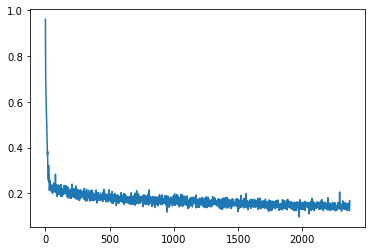

In [113]:
plt.plot(train_record['loss'])
save_fig_with_date('default_train_loss')

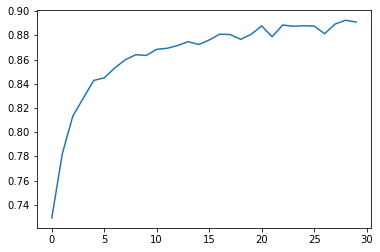

In [114]:
plt.plot(train_record['valid_acc'])
save_fig_with_date('default_train_valid_acc')

### Problem 2. Practice with nn.Sequential() (5 pts)
- `nn.Sequential` automatically stacks the `nn.Module`
    - If `x = nn.Sequential( nn.Conv1d(48, 12) , nn.ReLU() )`,
        - `out = x(input)` is same with `out` below
        - `x1 = nn.Conv1d(48,12)`, `x2=nn.ReLU()`, `out = x2(x1(input))`


In [ ]:
class StackManualLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv1d(16, 4, kernel_size=2)
    self.activation = nn.Sigmoid()
    self.layer2 = nn.Conv1d(4, 4, kernel_size=2)
    self.layer3 = nn.Conv1d(4, 1, kernel_size=2)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activation(out)
    out = self.layer2(out)
    out = self.activation(out)
    out = self.layer3(out)
    return out

class SequentialLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      '''
      TODO: Complete this nn.Sequential so that it computes exactly same thing with StackManualLayer
      '''
    )
  def forward(self, x):
    out = self.layers(x)
    return out
  
# Do not change the code below
torch.manual_seed(0)
manual_layer = StackManualLayer()
torch.manual_seed(0)
sequential_layer = SequentialLayer()

'''
The printed result has to be same
'''

test_dummy = torch.arange(128).view(1,16,8).float()
manual_out = manual_layer(test_dummy)
print(f"Output with Manual Stack Layer: {manual_out}")
sequential_out = sequential_layer(test_dummy)
print(f"Output with Sequential Layer: {sequential_out}")




### Problem 3. Make Your Own Conv Layers (15 pts)
- Complete the `self.conv_layer` of `YourModel`
- Train the model and compare the result
- In your report, explain your conv_layer and the training result
    - How did you change the structure of CNN?
    - What is the difference?

In [ ]:
class YourModel(AudioModel):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__(sr, n_fft, hop_length, n_mels, hidden_size, num_output)
    '''
      TODO: Complete your new conv layer =
      Example:
      self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU()
    )
      '''
    self.conv_layer = nn.Sequential(
    )

In [ ]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

## Save the figure with comparison of default setting
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.plot(your_train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
plt.plot(your_train_record['valid_acc'])
save_fig_with_date('your_conv_layer_comparison_with_default')

### Probelm 4. Try Various Settings and Report (20 pts)
- You can try different `n_fft`, `n_mels`, or `hidden_size`, or different `conv_layer` in your model
- Describe the result and your analysis in your report
    - Why you tried those changes
    - What you have expected from the result with those changes
    - What you got from the changes

In [ ]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

## Save the figure with comparison of default setting
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.plot(your_train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
plt.plot(your_train_record['valid_acc'])
save_fig_with_date('comparison_with_default')

In [ ]:
'''
Get the test result
'''
test_acc = validate_model(your_model, test_loader, DEV)
print(f"Calculated ROC_AUC value for Test Set is : {test_acc:.4f}")

### Problem 5 Complete Binary Cross Entropy Function (5 pts) 
- Complete the function that can calculate the Binary Cross Entropy for given prediction and target label without using `torch.BCELoss`
- ![bce](https://androidkt.com/wp-content/uploads/2021/05/Selection_099.png)

In [ ]:
def get_binary_cross_entropy(pred:torch.Tensor, target:torch.Tensor):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input (assume that the value is output of sigmoid function)
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Mean Binary Cross Entropy Loss value of every sample
  '''
  # TODO: Complete this function
  return 

test_model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=16)
test_model = test_model.to(DEV)
test_optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-3)
train_record = train_model(test_model, train_loader, valid_loader, test_optimizer, num_epochs=5, loss_func=get_binary_cross_entropy, device=DEV)
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
save_fig_with_date('handmade_bce_result')

### Problem 6. Complete Precision-Recall Area Under Curve Function (20 pts)
- One of the frequently used metric is Precision-Recall Area Under Curve (PR-AUC)
- Precision is (Number of true positive)/(Number of total positive predictions)
- Recall is (Number of true positive)/(Number of total positive ground-truth)
- Precision and recall values depend on threshold
- PR-AUC is the area under precision-recall curve of varying trheshold
- You can refer the pre-defined `get_roc_auc` function

In [ ]:
def get_precision_and_recall(pred:torch.Tensor, target:torch.Tensor, threshold:float):
  '''
  This function calculates precision and recall of given (prediction, target, threshold)
  
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output
    precision (torch.Tensor): (Number of true positive)/(Number of total positive predictions)
    recall (torch.Tensor): (Number of true positive)/(Number of total positive ground-truth)
    
  IMPORTANT:
    To prevent division by zero, make the denominator greater than zero.
  
  TODO: Complete this function
  '''
  
  # Write your code here
  
  precision = None
  recall = None
  
  
  '''
  Be careful for not returning nan because of division by zero
  '''
  assert not (torch.isnan(precision) or torch.isnan(recall))
  return precision, recall

def get_precision_recall_auc(pred:torch.Tensor, target:torch.Tensor, num_grid=500):
  '''
  This function returns PR_AUC value for a given prediction and target.
  Assume pred.shape == target.shape
  
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Area Under Curve value for Precision-Recall Curve
  
  TODO: Complete this function using get_precision_and_recall
  '''

  return


In [ ]:
'''
Test the get_precision_recall_auc
'''

dummy_pred = torch.Tensor([0.0285,     0.0004,     0.0483,     0.0003,     0.0074,     0.0141,
            0.0007,     0.0735,     0.0534,     0.0153,     0.0024,     0.0053,
            0.0004,     0.1033,     0.1007,     0.4314,     0.1744,     0.0119,
            0.0189,     0.0075,     0.0001,     0.1354,     0.0014,     0.0004,
            0.4431,     0.0236,     0.0005,     0.1276,     0.0173,     0.0000,
            0.0010,     0.1237,     0.0616,     0.1674,     0.0000,     0.0053,
            0.0984,     0.0608,     0.1783,     0.0689,     0.0509,     0.0011,
            0.0749,     0.0001,     0.6105,     0.0136,     0.2644,     0.0204,
            0.0005,     0.0001])
dummy_target = torch.Tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0])

'''
Printed result of code below has to be tensor(0.1753)
'''
get_precision_recall_auc(dummy_pred, dummy_target) 

In [ ]:
selected_model = model
pr_auc_value_valid = validate_model(selected_model, valid_loader, DEV, acc_func=get_precision_recall_auc)
pr_auc_value_test = validate_model(selected_model, test_loader, DEV, acc_func=get_precision_recall_auc)
print(f"Calculated PR_AUC value for Validation Set is : {pr_auc_value_valid:.4f}")
print(f"Calculated PR_AUC value for Test Set is : {pr_auc_value_test:.4f}")

### Problem 7: Load audio and make prediction (20 pts)
- Upload mp3 file of your choice
    - If you are using Colab, you can upload file by opening File Browser at the sidebar
- Try several audio files and report the result by comparing your expectation and model's output
- You can get different result by modifying `THRESHOLD`
    - `THRESHOLD` has to be a value between 0 and 1
    - If you lower the `THRESHOLD`, more tags will be printed out
- Complete `slice_audio` function (5 pts)

In [ ]:
your_audio_path = 'your_audio_file_path' #TODO
selected_model = model # Change it if you want to select model with different name

In [ ]:
def get_resampled_mono_audio_from_file(audio_file_path, target_sr):
  y, sr = torchaudio.load(your_audio_path)
  if sr!= selected_model.sr:
    y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=selected_model.sr)
  if y.shape[0] > 1:
    y = torch.sum(y, dim=0) / y.shape[0]
  
  return y

def slice_audio(audio_sample, sr, start_sec, end_sec):
  '''
  This function takes an audio sample, sampling rate, and start/end position of slice
  and returns the sliced audio sample.
  
  audio_sample (torch.Tensor): A sequence of audio samples in shape of (N,), where N is number of audio samples
  sr (int): Sampling rate of audio_sample
  start_sec (float): desired slice start position in seconds
  end_sec (float): desired slice end position in seconds
  
  output (torch.Tensor): A sequence of audio samples in shape of (int(sr*(end_sec-start_sec)), ) 
  
  
  TODO: Complete this function
  '''
  return

In [ ]:
'''
Run Model
'''


THRESHOLD = 0.2
y = get_resampled_mono_audio_from_file(your_audio_file, selected_model.sr)

'''
You can slice your desired position
'''
sliced_y = slice_audio(y, selected_model.sr, 0, 30) 


with torch.no_grad():
  pred = selected_model(sliced_y.unsqueeze(0).to(DEV)).to('cpu')
pred = pred[0]
ipd.display(ipd.Audio(sliced_y, rate=selected_model.sr))
print(f"Predicted tags are: {model.vocab[torch.where(pred>THRESHOLD)]}")